In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy as np
from os.path import expanduser
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel

from joblib import Parallel, delayed

import numpy as np
import pandas as pd
import xarray as xr

import torch
import torch.distributions as dist
import torch.nn as nn
import torch.nn.functional as F
torch.pi = torch.tensor(np.pi)

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda")

In [2]:
class RBF(nn.Module):
    def __init__(self, dims, ls, scale):
        super().__init__()
        self.dims = dims
        self.log_ls = nn.Parameter(torch.log(torch.tensor(ls)).reshape(1, self.dims))
        self.log_scale = nn.Parameter(torch.log(torch.tensor(scale)).reshape(()))
        
    def forward(self, x1, x2):
        assert x1.shape[1] == self.dims
        assert x2.shape[1] == self.dims
        
        ls = F.softplus(self.log_ls)
        scale = F.softplus(self.log_scale)
        
        x1 = x1 / ls
        x2 = x2 / ls
        
        def square_distance_fn(x1, x2):
            return ((x1 - x2) ** 2).sum()
        
        vdist = torch.vmap(square_distance_fn, in_dims=(None, 0))
        vdist = torch.vmap(vdist, in_dims=(0, None))
        square_distance = vdist(x1, x2)
        
        # print("zdebug", vdist(x1, x2).shape)
        
        return scale * torch.exp(-0.5 * square_distance)
    
# vectorized way
def loss_fn(covar, y):
    chol = torch.linalg.cholesky(covar)
    alpha = torch.cholesky_solve(y, chol)
    
    first_term = (0.5 * y.T @ alpha).squeeze()
    second_term = torch.log(torch.diag(chol)).sum()
    # third_term = 0.5 * len(y) * torch.log(2 * torch.pi)
    # Third term is ignored because it will make loss biased due to missing values
    
    return (first_term + second_term).squeeze(), alpha

# def loss_fn(covar, y):
#     return -dist.MultivariateNormal(loc=torch.zeros(1), covariance_matrix=covar).log_prob(y).sum()

### Small testing

In [3]:
ls = torch.rand(2) * 5
var = torch.rand(()) * 5

gpytorch_kernel = ScaleKernel(RBFKernel(2))
gpytorch_kernel.base_kernel.lengthscale = ls
gpytorch_kernel.outputscale = var

x1 = torch.randn(3, 2)
x2 = torch.randn(3, 2)
print(gpytorch_kernel(x1, x2).evaluate_kernel().to_dense())

print(RBF(2, ls, var)(x1, x2))

tensor([[0.7243, 0.7576, 0.7078],
        [0.7054, 0.7699, 0.6712],
        [0.7172, 0.7485, 0.7098]], grad_fn=<MulBackward0>)
tensor([[0.2658, 0.3081, 0.2243],
        [0.2352, 0.3378, 0.1715],
        [0.2534, 0.2896, 0.2284]], grad_fn=<MulBackward0>)


/tmp/ipykernel_1699211/835085139.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_ls = nn.Parameter(torch.log(torch.tensor(ls)).reshape(1, self.dims))
/tmp/ipykernel_1699211/835085139.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_scale = nn.Parameter(torch.log(torch.tensor(scale)).reshape(()))


In [4]:
region = "la_or_ve"
data = xr.load_dataset(expanduser(f"~/aqmsp/projects/better_interpol/data/purpleair/{region}/data.nc"))
data

<xarray.Dataset>
Dimensions:      (time: 9417, station: 1046)
Coordinates:
  * time     (time) time64[ns] 2021-06-01 ... 2022-06-30T23:00:00
  * station  (station) object '61982' '62064' ... '351628' '351634'
    lat          (station) float64 34.02 33.84 34.07 ... 33.81 33.75 33.83
    lon          (station) float64 -118.5 -118.3 -118.2 ... -118.3 -118.3
Data variables:
    value        (time, station) float64 10.12 nan 48.81 ... 12.73 14.1

In [13]:
abs_errors = {0: [], 1: [], 2: [], 3: [], 4: []}
n_candidates = {0: [], 1: [], 2: [], 3: [], 4: []}
for fold_id in range(5):
    print(f"Fold {fold_id}")
    test_locs = np.load(expanduser(f"~/aqmsp/projects/better_interpol/data/purpleair/{region}/test_{fold_id}.npy"))
    train_locs = np.load(expanduser(f"~/aqmsp/projects/better_interpol/data/purpleair/{region}/train_{fold_id}.npy"))
    
    train_data = data.sel(station=train_locs)
    test_data = data.sel(station=test_locs)
    train_df_per_ts = train_data.isel(time=0).to_dataframe()
    test_df_per_ts = test_data.isel(time=0).to_dataframe()
    train_X = torch.tensor(train_df_per_ts[["lat", "lon"]].values, dtype=torch.float32)
    test_X = torch.tensor(test_df_per_ts[["lat", "lon"]].values, dtype=torch.float32)
    
    # scaling
    x_min = torch.tensor([data.lat.min().item(), data.lon.min().item()]).reshape(1, 2)
    x_max = torch.tensor([data.lat.max().item(), data.lon.max().item()]).reshape(1, 2)
    y_mean = train_data.value.mean().item()
    y_std = train_data.value.std().item()
    
    train_X = ((train_X - x_min) / (x_max - x_min)).to(device)
    test_X = ((test_X - x_min) / (x_max - x_min)).to(device)
    train_data["value"] = (train_data["value"] - y_mean) / y_std
    
    timestamps = train_data.sel(time=slice("2021-11", "2021-12")).time.values
    print("Start", timestamps[0], "End", timestamps[-1])
    n_timestamps = len(timestamps)
    mass_y = torch.zeros(n_timestamps, len(train_data.station), 1).to("cuda")
    
    # One time preperation
    print("One time preperation")
    dummy_covar1 = torch.zeros(n_timestamps, len(train_data.station), len(train_data.station))
    dummy_covar2 = torch.zeros(n_timestamps, len(train_data.station), len(train_data.station))
    for ts_id, ts in enumerate(tqdm(timestamps)):
        tmp_train_df = train_data.sel(time=ts).to_dataframe()
        null_idx = tmp_train_df["value"].isna().values
        
        # Update y
        # y_local_mean = tmp_train_df["value"][~null_idx].mean().item()
        # mass_y[ts_id, ~null_idx] = (torch.tensor(tmp_train_df["value"].values[~null_idx], dtype=torch.float32, device=device) - y_local_mean).reshape(-1, 1)
        mass_y[ts_id, ~null_idx] = (torch.tensor(tmp_train_df["value"].values[~null_idx], dtype=torch.float32, device=device)).reshape(-1, 1)
        
        # Update dummy covariance
        dummy_covar1[ts_id, null_idx, :] = np.nan
        dummy_covar1[ts_id, :, null_idx] = np.nan
        dummy_covar2[ts_id, null_idx, null_idx] = np.nan
        
    zero_idx = torch.isnan(dummy_covar1)
    one_idx = torch.isnan(dummy_covar2)

    rbf = RBF(2, [0.5, 0.5], 2.0).to(device)
    # rbf = ScaleKernel(MaternKernel(num_active_dims=2, ard=True)).to(device)
    log_noise_var = nn.Parameter(torch.tensor(np.log(0.1), device=device, dtype=torch.float32))
    optimizer = torch.optim.Adam(list(rbf.parameters()) + [log_noise_var], lr=1e-2)
    
    losses = []
    print("Training")
    pbar = tqdm(range(1000))
    min_loss = np.inf
    for epoch in pbar:
        covar = rbf(train_X, train_X)#.evaluate_kernel().to_dense()
        covar.diagonal().add_(torch.exp(log_noise_var))
        mass_covar = covar[np.newaxis, ...].repeat(n_timestamps, 1, 1)
        mass_covar[zero_idx] = 0.0
        mass_covar[one_idx] = 1.0
        
        # # Every time preperation
        # for ts_id, ts in enumerate(train_data.time.values):
        #     tmp_train_df = train_data.sel(time=ts).to_dataframe()
        #     null_idx = tmp_train_df["value"].isna().values
            
        #     # Update covariance
        #     mass_covar[ts_id, null_idx, :] = 0.0
        #     mass_covar[ts_id, :, null_idx] = 0.0
        #     mass_covar[ts_id, null_idx, null_idx] = 1.0
            
        # small testing
        # traditional way
        # testing_df = tmp_train_df.dropna(subset="value")
        # X = torch.tensor(testing_df[["lat", "lon"]].values).float()
        # X = (X - x_min) / (x_max - x_min).float()
        # y = torch.tensor(testing_df["value"].values).float()
        # m = y.mean().reshape(1).repeat(len(y)).float()
        # y = y - m
        # covar = rbf(X, X)
        # covar.diagonal().add_(1e-3)
        # loss1 = -dist.MultivariateNormal(torch.zeros(covar.shape[0]).float(), covar).log_prob(y)
        # print(loss1 - len(y)/2 * torch.log(2 * torch.pi))
        
        # vmap_loss = torch.vmap(loss_fn)(mass_covar.float(), mass_y.float())
        # print(vmap_loss[:10])
        # break
        vloss, valpha = torch.vmap(loss_fn)(mass_covar, mass_y)
        loss = vloss.mean() # + vloss.std()
        if loss.item() < min_loss:
            min_loss = loss.item()
            print("Best params at epoch", epoch, "ls", rbf.log_ls.exp().detach().cpu().numpy(), "scale", rbf.log_scale.exp().detach().cpu().numpy(), "noise", log_noise_var.exp().detach().cpu().numpy())
        losses.append(loss.item())
        pbar.set_description(f"Loss {loss.item():.4f}")
        loss.backward()
        optimizer.step()

    ## Prediction
    print("Prediction")
    for ts_id, ts in enumerate(tqdm(timestamps)):
        tmp_test_df = test_data.sel(time=ts).to_dataframe()
        tmp_test_df = tmp_test_df.dropna(subset=["value"])
        test_X = torch.tensor(tmp_test_df[["lat", "lon"]].values, dtype=torch.float32)
        test_X = ((test_X - x_min) / (x_max - x_min)).to(device)
        
        covar = rbf(test_X, train_X)
        pred = covar@valpha[ts_id] * y_std + y_mean
        pred = pred.squeeze().cpu().detach().numpy()
        true = tmp_test_df["value"].values
        abs_errors[fold_id].append(np.abs(pred - true).sum())
        n_candidates[fold_id].append(len(tmp_test_df))

Fold 0
Start 2021-11-01T00:00:00.000000000 End 2021-12-31T23:00:00.000000000
One time preperation


  0%|          | 0/1436 [00:00<?, ?it/s]

Training


  0%|          | 0/1000 [00:00<?, ?it/s]

Best params at epoch 0 ls [[0.5 0.5]] scale 2.0 noise 0.1
Best params at epoch 1 ls [[0.49502492 0.49502492]] scale 2.0201004 noise 0.10100502
Best params at epoch 2 ls [[0.4902698  0.49026945]] scale 2.0396984 noise 0.10198532
Best params at epoch 3 ls [[0.48559514 0.4855942 ]] scale 2.0593424 noise 0.102968186
Best params at epoch 4 ls [[0.48095337 0.48095176]] scale 2.0792282 noise 0.10396334
Best params at epoch 5 ls [[0.4763233  0.47632095]] scale 2.0994513 noise 0.1049755
Best params at epoch 6 ls [[0.47169444 0.47169128]] scale 2.1200678 noise 0.10600742
Best params at epoch 7 ls [[0.46706104 0.46705714]] scale 2.1411135 noise 0.10706089
Best params at epoch 8 ls [[0.46242023 0.46241558]] scale 2.1626158 noise 0.10813722
Best params at epoch 9 ls [[0.45777074 0.45776537]] scale 2.1845953 noise 0.10923743
Best params at epoch 10 ls [[0.45311219 0.4531062 ]] scale 2.2070692 noise 0.1103623
Best params at epoch 11 ls [[0.448445   0.44843844]] scale 2.2300515 noise 0.111512505
Best 

  0%|          | 0/1436 [00:00<?, ?it/s]

Fold 1
Start 2021-11-01T00:00:00.000000000 End 2021-12-31T23:00:00.000000000
One time preperation


  0%|          | 0/1436 [00:00<?, ?it/s]

Training


  0%|          | 0/1000 [00:00<?, ?it/s]

Best params at epoch 0 ls [[0.5 0.5]] scale 2.0 noise 0.1
Best params at epoch 1 ls [[0.49502492 0.49502492]] scale 2.0201004 noise 0.10100502
Best params at epoch 2 ls [[0.49026707 0.49026683]] scale 2.0397134 noise 0.101985425
Best params at epoch 3 ls [[0.48558804 0.48558754]] scale 2.0593815 noise 0.102968454
Best params at epoch 4 ls [[0.48094085 0.48093998]] scale 2.0792987 noise 0.10396381
Best params at epoch 5 ls [[0.47630465 0.47630346]] scale 2.0995586 noise 0.10497622
Best params at epoch 6 ls [[0.47166914 0.4716677 ]] scale 2.1202152 noise 0.106008425
Best params at epoch 7 ls [[0.46702898 0.46702728]] scale 2.141304 noise 0.10706221
Best params at epoch 8 ls [[0.46238142 0.46237954]] scale 2.1628506 noise 0.108138874
Best params at epoch 9 ls [[0.45772547 0.4577235 ]] scale 2.184874 noise 0.10923939
Best params at epoch 10 ls [[0.45306098 0.453059  ]] scale 2.2073896 noise 0.11036454
Best params at epoch 11 ls [[0.4483886 0.4483866]] scale 2.2304106 noise 0.11151504
Best 

  0%|          | 0/1436 [00:00<?, ?it/s]

Fold 2
Start 2021-11-01T00:00:00.000000000 End 2021-12-31T23:00:00.000000000
One time preperation


  0%|          | 0/1436 [00:00<?, ?it/s]

Training


  0%|          | 0/1000 [00:00<?, ?it/s]

Best params at epoch 0 ls [[0.5 0.5]] scale 2.0 noise 0.1
Best params at epoch 1 ls [[0.49502492 0.49502492]] scale 2.0201004 noise 0.10100502
Best params at epoch 2 ls [[0.49026808 0.49026716]] scale 2.0397117 noise 0.101985425
Best params at epoch 3 ls [[0.4855906 0.4855882]] scale 2.0593777 noise 0.102968454
Best params at epoch 4 ls [[0.48094535 0.48094115]] scale 2.0792916 noise 0.10396384
Best params at epoch 5 ls [[0.47631133 0.47630507]] scale 2.0995479 noise 0.10497627
Best params at epoch 6 ls [[0.47167814 0.47166964]] scale 2.1202006 noise 0.10600851
Best params at epoch 7 ls [[0.46704027 0.4670295 ]] scale 2.1412857 noise 0.10706232
Best params at epoch 8 ls [[0.462395 0.462382]] scale 2.1628284 noise 0.108138986
Best params at epoch 9 ls [[0.45774123 0.45772603]] scale 2.184848 noise 0.10923949
Best params at epoch 10 ls [[0.4530787  0.45306155]] scale 2.2073605 noise 0.11036467
Best params at epoch 11 ls [[0.44840798 0.4483891 ]] scale 2.2303784 noise 0.111515164
Best par

  0%|          | 0/1436 [00:00<?, ?it/s]

Fold 3
Start 2021-11-01T00:00:00.000000000 End 2021-12-31T23:00:00.000000000
One time preperation


  0%|          | 0/1436 [00:00<?, ?it/s]

Training


  0%|          | 0/1000 [00:00<?, ?it/s]

Best params at epoch 0 ls [[0.5 0.5]] scale 2.0 noise 0.1
Best params at epoch 1 ls [[0.49502492 0.49502492]] scale 2.0201004 noise 0.10100502
Best params at epoch 2 ls [[0.4902681  0.49026906]] scale 2.039702 noise 0.101985276
Best params at epoch 3 ls [[0.48559067 0.48559323]] scale 2.0593514 noise 0.10296807
Best params at epoch 4 ls [[0.48094535 0.4809499 ]] scale 2.079245 noise 0.103963114
Best params at epoch 5 ls [[0.47631124 0.4763182 ]] scale 2.0994775 noise 0.104975164
Best params at epoch 6 ls [[0.4716779  0.47168747]] scale 2.1201046 noise 0.106006965
Best params at epoch 7 ls [[0.46703988 0.4670522 ]] scale 2.141162 noise 0.10706033
Best params at epoch 8 ls [[0.46239442 0.46240953]] scale 2.1626768 noise 0.10813653
Best params at epoch 9 ls [[0.45774037 0.4577582 ]] scale 2.1846688 noise 0.1092366
Best params at epoch 10 ls [[0.4530776  0.45309797]] scale 2.207155 noise 0.11036133
Best params at epoch 11 ls [[0.4484067 0.4484293]] scale 2.230149 noise 0.11151142
Best para

  0%|          | 0/1436 [00:00<?, ?it/s]

Fold 4
Start 2021-11-01T00:00:00.000000000 End 2021-12-31T23:00:00.000000000
One time preperation


  0%|          | 0/1436 [00:00<?, ?it/s]

Training


  0%|          | 0/1000 [00:00<?, ?it/s]

Best params at epoch 0 ls [[0.5 0.5]] scale 2.0 noise 0.1
Best params at epoch 1 ls [[0.49502492 0.49502492]] scale 2.0201004 noise 0.10100502
Best params at epoch 2 ls [[0.49026707 0.49026817]] scale 2.0397513 noise 0.10198515
Best params at epoch 3 ls [[0.48558792 0.48559093]] scale 2.0594878 noise 0.10296777
Best params at epoch 4 ls [[0.48094043 0.48094603]] scale 2.079496 noise 0.1039626
Best params at epoch 5 ls [[0.47630376 0.47631255]] scale 2.0998611 noise 0.1049744
Best params at epoch 6 ls [[0.47166762 0.47168005]] scale 2.1206355 noise 0.10600589
Best params at epoch 7 ls [[0.46702665 0.46704304]] scale 2.1418493 noise 0.10705894
Best params at epoch 8 ls [[0.4623782  0.46239874]] scale 2.163523 noise 0.10813483
Best params at epoch 9 ls [[0.45772123 0.45774594]] scale 2.1856697 noise 0.10923457
Best params at epoch 10 ls [[0.45305574 0.45308444]] scale 2.2082975 noise 0.11035899
Best params at epoch 11 ls [[0.4483824  0.44841468]] scale 2.2314105 noise 0.11150881
Best para

  0%|          | 0/1436 [00:00<?, ?it/s]

<Axes: xlabel='time'>

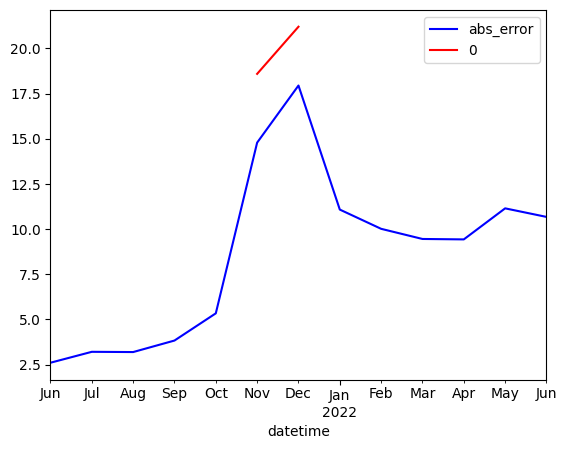

In [14]:
concat_errors = np.concatenate([np.array(abs_errors[i]).reshape(1, -1) for i in range(5)])
concat_candiates = np.concatenate([np.array(n_candidates[i]).reshape(1, -1) for i in range(5)])
gp_errors = concat_errors.sum(axis=0) / concat_candiates.sum(axis=0)

rf_errors = pd.read_csv("/tmp/mae_rf.csv")
rf_errors['time'] = pd.to_time(rf_errors['time'])
rf_errors = rf_errors.set_index("time")
fig, ax = plt.subplots()
rf_errors.plot(label="RF", ax=ax, color="blue")
pd.DataFrame(gp_errors, index=timestamps).resample("1M").mean().plot(label="GP", ax=ax, color="red")
# rf_errors

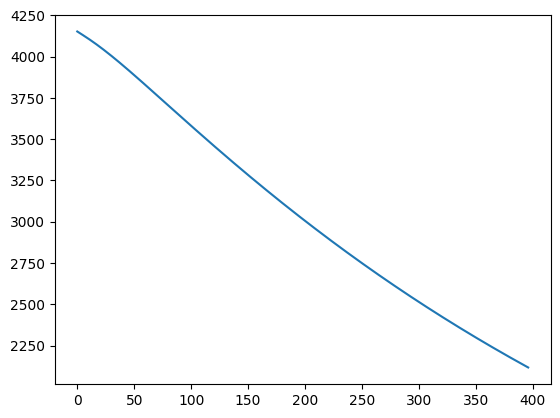

In [9]:
plt.plot(losses)

In [10]:
rbf.log_ls.exp(), rbf.log_scale.exp(), log_noise_var.exp()
# rbf.base_kernel.lengthscale, rbf.outputscale, torch.exp(log_noise_var)

(tensor([[0.5457, 0.5405]], device='cuda:0', grad_fn=<ExpBackward0>),
 tensor(1.8291, device='cuda:0', grad_fn=<ExpBackward0>),
 tensor(0.1803, device='cuda:0', grad_fn=<ExpBackward0>))

### Predict

## Appendix

In [90]:
a = torch.randn(3, 4)
a = a@a.T
b = torch.eye(6) #* 1.8
b[:3, :3] = a
# b[::2, ::2] = a
y = torch.randn(3, 1)
yb = torch.randn(6, 1)
yb[:3] = y
# yb[::2] = y

print("Matrix A")
print(a)
print("Matrix B")
print(b)
print()
print("Inverse of A")
print(torch.inverse(a))
print("Inverse of B")
print(torch.inverse(b))
print()
print("Solve K^-1 y")
print(torch.inverse(a)@y)
print(torch.inverse(b)@yb)
print()
print("Solve K^-1 y cholesky way")
chol_a = torch.cholesky(a)
chol_b = torch.cholesky(b)
print(torch.cholesky_solve(y, chol_a))
print(torch.cholesky_solve(yb, chol_b))
print()
print("Log Determinant of A")
print(torch.log(torch.linalg.det(a)))
print(torch.log(torch.linalg.det(b)))
print()
print("Log Determinant of A cholesky way")
print(torch.log(torch.diag(chol_a)).sum() * 2)
print(torch.log(torch.diag(chol_b)).sum() * 2)

Matrix A
tensor([[ 1.6997,  1.5063, -0.0402],
        [ 1.5063,  2.5354,  0.3648],
        [-0.0402,  0.3648,  4.5117]])
Matrix B
tensor([[ 1.6997,  1.5063, -0.0402,  0.0000,  0.0000,  0.0000],
        [ 1.5063,  2.5354,  0.3648,  0.0000,  0.0000,  0.0000],
        [-0.0402,  0.3648,  4.5117,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000]])

Inverse of A
tensor([[ 1.2659, -0.7626,  0.0729],
        [-0.7626,  0.8584, -0.0762],
        [ 0.0729, -0.0762,  0.2285]])
Inverse of B
tensor([[ 1.2659, -0.7626,  0.0729,  0.0000,  0.0000,  0.0000],
        [-0.7626,  0.8584, -0.0762,  0.0000,  0.0000,  0.0000],
        [ 0.0729, -0.0762,  0.2285,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,

In [115]:
x = torch.randn(10, 2)
y = torch.randn(10, 1)
y[1] = 0.0
y[4] = 0.0
y[5] = 0.0

rbf = RBF(2, [0.8, 1.2], 1.0)
covar = rbf(x, x)
covar.diagonal().add_(1e-3)

# traditional way
tmp_covar = covar[np.array([0, 2, 3, 6, 7, 8, 9]), :]
tmp_covar = tmp_covar[:, np.array([0, 2, 3, 6, 7, 8, 9])]
loss1 = -dist.MultivariateNormal(torch.zeros(7), tmp_covar).log_prob(y[np.array([0, 2, 3, 6, 7, 8, 9])].squeeze())
print(loss1)

# non-traditional way
covar[np.array([1, 4, 5]), :] = 0.0
covar[:, np.array([1, 4, 5])] = 0.0
covar[np.array([1, 4, 5]), np.array([1, 4, 5])] = 1.0
loss2 = -dist.MultivariateNormal(torch.zeros(10), covar).log_prob(y.squeeze()) - 3/2 * np.log(2 * np.pi)
print(loss2)

tensor(87.6750, grad_fn=<NegBackward0>)
tensor(87.6750, grad_fn=<SubBackward0>)


In [22]:
import jaxtyping
import jax.numpy as jnp
import torch
isinstance(torch.tensor([1,.2]).reshape(-1, 1), jaxtyping.Float[torch.Tensor, "... 1"])

True